In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import random
import imgaug.augmenters as iaa
import cv2


In [3]:
img = cv2.imread('D:/SemiSegmen20221/datasets/2007_000032.jpg')
lbl = cv2.imread('D:/SemiSegmen20221/datasets/2007_000032.jpg')

print(img[:,:,0].shape)

(281, 500)


In [8]:
class Rand_Augment():
    def __init__(self, Numbers=3, Magnitude=7, max_Magnitude=10, transforms=None, p=1.0):
        self.transforms = [
            'contrast_gamma',
            'contrast_linear',
            'brightness',
            'brightness_channel',
            'equalize',
            'hsv',
            'invert_channel',
            'blur',
            'noise_gau',
            'noise_pos',
            'channle_shuffle',
            'dropout',
            'coarse_dropout',
            'multiply',
            'salt_pepper',
            'solarize',
            'jpeg_compression',
        ]

        self.pad_r_half = [0, 0]
        self.pad_c_half = [0, 0]
        self.crop_beg = [0, 0]

        assert p <= 1 and p >= 0
        self.p = p

        if transforms is None:
            self.transforms_input = self.transforms
        else:
            assert len(transforms) <= len(self.transforms)
            for i in range(0, len(transforms)):
                assert transforms[i] in self.transforms
            self.transforms_input = transforms

        if Numbers is None:
            self.Numbers = min(3, len(self.transforms_input) // 2)
        else:
            self.Numbers = Numbers

        if max_Magnitude is None:
            self.max_Magnitude = 10
        else:
            self.max_Magnitude = max_Magnitude
        assert Magnitude >= 0 and Magnitude <= self.max_Magnitude

        self.Magnitude = Magnitude

        self.ranges = {
            # these  Magnitude   range , you  must test  it  yourself , see  what  will happen  after these  operation
            "contrast_gamma":     np.linspace(0.5,  1.5, self.max_Magnitude),
            "contrast_linear":    np.linspace(0.5, 2.0, self.max_Magnitude),
            "brightness":         np.linspace(-20, 50, self.max_Magnitude),
            "brightness_channel": np.linspace(-20, 50, self.max_Magnitude),
            "equalize":           [0] * self.max_Magnitude,
            "hsv":                np.linspace(-20, 20, self.max_Magnitude),
            "invert_channel":     [0] * self.max_Magnitude,
            "blur":               np.linspace(1.5, 2.0, self.max_Magnitude),
            "noise_gau":          np.linspace(0.03*255, 0.08*255, self.max_Magnitude),
            "noise_pos":          np.linspace(10, 15.0, self.max_Magnitude),
            'channle_shuffle':    [0] * self.max_Magnitude,
            'dropout':            [0] * self.max_Magnitude,
            'coarse_dropout':     [0] * self.max_Magnitude,
            'multiply':           [0] * self.max_Magnitude,
            'salt_pepper':        [0] * self.max_Magnitude,
            'solarize':           [0] * self.max_Magnitude,
            'jpeg_compression':   [0] * self.max_Magnitude,
        }

        self.func_init = {
            "contrast_gamma":     self.initCtsGamma,
            "contrast_linear":    self.initCtsLinear,
            "brightness":         self.initTuneBrightness,
            "brightness_channel": self.initTuneBrightnessChannel,
            "equalize":           self.initEqualize,
            "hsv":                self.inithsv,
            "invert_channel":     self.initInvertChannel,
            "blur":               self.initBlur,
            "noise_gau":          self.initNoiseGauss,
            "noise_pos":          self.initNoisePoisson,
            'channle_shuffle':    self.initChannelShuffle,
            'dropout':            self.initDropout,
            'coarse_dropout':     self.initCoarseDropout,
            'multiply':           self.initMultiply,
            'salt_pepper':        self.initSaltAndPepper,
            'solarize':           self.initSolarize,
            'jpeg_compression':   self.initJpegCompression,
        }

        self.func = {
            "contrast_gamma":     self.randomCtsGamma,
            "contrast_linear":    self.randomCtsLinear,
            "brightness":         self.randomTuneBrightness,
            "brightness_channel": self.randomTuneBrightnessChannel,
            "equalize":           self.randomEqualize,
            "hsv":                self.randomhsv,
            "invert_channel":     self.randomInvertChannel,
            "blur":               self.randomBlur,
            "noise_gau":          self.randomNoiseGauss,
            "noise_pos":          self.randomNoisePoisson,
            "channle_shuffle":    self.randomChannleShuffle,
            "dropout":            self.randomDropout,
            "coarse_dropout":     self.randomCoarseDropout,
            "multiply":           self.randomMultiply,
            "salt_pepper":        self.randomSaltAndPeper,
            "solarize":           self.randomSolarize,
            "jpeg_compression":   self.randomJpegCompression,
        }

        self.initAllAugmentOP(self.Magnitude)


    def initNoiseGauss(self, magnitude):
        self.tune_noise_gas = iaa.AdditiveGaussianNoise(scale=magnitude)

    def randomNoiseGauss(self, image, mask):
        image = self.tune_noise_gas.augment_image(image)
        return image, mask


    def initNoisePoisson(self, magnitude):
        self.tune_noise_pos = iaa.AdditivePoissonNoise(lam=magnitude)

    def randomNoisePoisson(self, image, mask):
        image = self.tune_noise_pos.augment_image(image)
        return image, mask


    def initTuneBrightness(self, magnitude):
        self.tune_brightness = iaa.Add(magnitude)

    def randomTuneBrightness(self, image, mask):
        image = self.tune_brightness.augment_image(image)
        return image, mask


    def initTuneBrightnessChannel(self, magnitude):
        self.tune_brightness_channel = iaa.Add(magnitude, per_channel=True)

    def randomTuneBrightnessChannel(self, image, mask):
        image = self.tune_brightness_channel.augment_image(image)
        return image, mask


    def initEqualize(self, magnitude):
        self.tune_equalize = iaa.HistogramEqualization()

    def randomEqualize(self, image, mask):
        image = self.tune_equalize.augment_image(image)
        return image, mask


    def initBlur(self, magnitude):
        self.tune_blur = iaa.GaussianBlur(magnitude)

    def randomBlur(self, image, mask):
        image = self.tune_blur.augment_image(image)
        return image, mask


    def inithsv(self, magnitude):
        self.tune_hsv = iaa.AddToHueAndSaturation(int(magnitude), per_channel=True)

    def randomhsv(self, image, mask):
        image = self.tune_hsv.augment_image(image)
        return image, mask


    def initCtsGamma(self, magnitude):
        self.tune_contrast_gamma = iaa.GammaContrast(magnitude, per_channel=True)

    def randomCtsGamma(self, image, mask):
        image = self.tune_contrast_gamma.augment_image(image)
        return image, mask


    def initCtsLinear(self, magnitude):
        self.tune_contrast_linear = iaa.LinearContrast(magnitude, per_channel=True)

    def randomCtsLinear(self, image, mask):
        image = self.tune_contrast_linear.augment_image(image)
        return image, mask

    def initFlipHorizontal(self, magnitude):
        self.tune_flip_h = iaa.Flipud(1.0)

    def randomFlipHorizontal(self, image, mask):
        image = self.tune_flip_h.augment_image(image)
        mask = self.tune_flip_h.augment_image(mask)
        return image.copy(), mask.copy()


    def initFlipVerticle(self, magnitude):
        self.tune_flip_v = iaa.Fliplr(1.0)

    def randomFlipVerticle(self, image, mask):
        image = self.tune_flip_v.augment_image(image)
        mask = self.tune_flip_v.augment_image(mask)
        return image.copy(), mask.copy()

    def initCloud(self, magnitude):
        self.tune_cloud = iaa.CloudLayer(intensity_mean=250,
                                    intensity_freq_exponent=-2,
                                    intensity_coarse_scale=10,
                                    alpha_min=0.3,
                                    alpha_multiplier=0.5,
                                    alpha_size_px_max=8,
                                    alpha_freq_exponent=-2.2,
                                    sparsity=0.9,
                                    density_multiplier=0.8)

    def randomCloud(self, image, mask):
        image = self.tune_cloud.augment_image(image)
        assert len(image)==0, print(len(image), image)
        image = image[0]
        return image, mask

    def initInvertChannel(self, magnitude):
        pass

    def randomInvertChannel(self, image, mask):
        assert image.shape[2] == 3
        b, g, r = cv2.split(image)
        image = cv2.merge([r, g, b])
        return image, mask

    def initChannelShuffle(self, magnitude):
        self.channel_shuffle = iaa.ChannelShuffle(1)

    def randomChannleShuffle(self, image, mask):
        image = self.channel_shuffle.augment_image(image)
        return image, mask

    def initDropout(self, magnitude):
        self.dropout = iaa.Dropout((0.2, 0.5), per_channel=True)
    def randomDropout(self, image, mask):
        image = self.dropout.augment_image(image)
        return image, mask

    def initCoarseDropout(self, magnitude):
        self.coarse_dropout = iaa.CoarseDropout(0.2, per_channel=True, size_px=(2, 5))
    def randomCoarseDropout(self, image, mask):
        image = self.coarse_dropout.augment_image(image)
        return image, mask

    def initMultiply(self, magnitude):
        self.multiply = iaa.Multiply((0.25, 2.5), per_channel=True)
    def randomMultiply(self, image, mask):
        image = self.multiply.augment_image(image)
        return image, mask

    def initSaltAndPepper(self, magnitude):
        self.salt_pepper = iaa.SaltAndPepper((0, 0.1), per_channel=True)
    def randomSaltAndPeper(self, image, mask):
        image = self.salt_pepper.augment_image(image)
        return image, mask

    def initSolarize(self, magnitude):
        self.Solarize = iaa.Solarize(per_channel=False)
    def randomSolarize(self, image, mask):
        image = self.Solarize.augment_image(image)
        return image, mask

    def initJpegCompression(self, magnitude):
        self.JpegCompression = iaa.JpegCompression(compression=(85, 95))
    def randomJpegCompression(self, image, mask):
        image = self.JpegCompression.augment_image(image)
        return image, mask

    def initRotate(self, magnitude):
        self.tune_rotate = iaa.Affine(rotate=magnitude, order=0)

    def randomRotate(self, image, mask):
        image = self.tune_rotate.augment_image(image)
        mask = self.tune_rotate.augment_image(mask)
        return image, mask

    def initShear(self, magnitude):
        self.tune_shear = iaa.Affine(shear=magnitude, order=0)

    def randomShear(self, image, mask):
        image = self.tune_shear.augment_image(image)
        mask = self.tune_shear.augment_image(mask)
        return image, mask

    def initTranslate_x(self, magnitude):
        self.tune_translate = iaa.Affine(translate_px={"x": int(magnitude), "y": 0})

    def randomTranslate_x(self, image, mask):
        image = self.tune_translate.augment_image(image)
        mask = self.tune_translate.augment_image(mask)
        return image, mask

    def initTranslate_y(self, magnitude):
        self.tune_translate = iaa.Affine(translate_px={"x": 0, "y": int(magnitude)})

    def randomTranslate_y(self, image, mask):
        image = self.tune_translate.augment_image(image)
        mask = self.tune_translate.augment_image(mask)
        return image, mask


    def initScale(self, magnitude):
        scale = random.uniform(0.5, 2)
        self.tune_scale = iaa.Affine(scale=scale, order=0)

    def randomScale(self, image, mask):
        image = self.tune_scale.augment_image(image)
        mask = self.tune_scale.augment_image(mask)
        return image, mask

    def initAllAugmentOP(self, magnitude):
        assert len(self.func_init) == len(self.func) == len(self.transforms) == len(self.ranges)
        M = min(magnitude, self.max_Magnitude)
        for i in range(0, len(self.transforms)):
            op_name = self.transforms[i]
            operation_init = self.func_init[op_name]
            mag = self.ranges[op_name][M]
            operation_init(mag)

    def randAugment(self):
        sampled_ops = random.sample(self.transforms_input, self.Numbers)
        dict_ops = {}
        for i in range(len(sampled_ops)):
            dict_ops[self.transforms_input.index(sampled_ops[i])] = sampled_ops[i]

        sampled_ops_new = [dict_ops[key] for key in sorted(dict_ops.keys())]
        return sampled_ops_new

    def __call__(self, image, mask):
        image = image.astype(np.uint8)
        if np.random.random() > self.p:
            return image, mask
        else:
            operations = self.randAugment()
            for op_name in operations:
                operation = self.func[op_name]
                image, mask = operation(image, mask)
            return image, mask



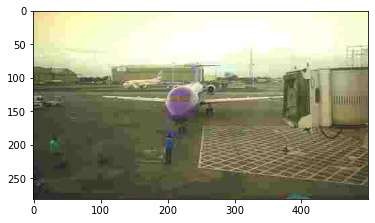

In [33]:
rand = Rand_Augment()
new_img, new_lbl = rand(img,lbl)
plt.imshow(new_img)

In [60]:
lst = [0,1,2]
random.shuffle(lst)
print(lst)

[0, 2, 1]


In [7]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
print(np.stack((a, b),axis=-1).shape)
print(a.shape)
print(np.stack((a, b),axis=-1))

(3, 2)
(3,)
[[1 4]
 [2 5]
 [3 6]]


In [4]:
def add_gaussian_noise(image,lam = 10):
    image = image.astype(np.float32)
    shape = image.shape[:2]

    mean = 0
    sigma = random.uniform(0,0.1) ** 0.5
    gamma = 0.25
    alpha = 0.75
    beta = 1 - alpha

    gaussian = np.random.poisson(lam=lam, size = (shape[0], shape[1], 1)).astype(np.float32)
    gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
    #gaussian_img = image * 0.75 + 0.25 * gaussian + 0.25
    gaussian_img = cv2.addWeighted(image, alpha, beta * gaussian, beta, gamma)
    gaussian_img = np.uint8(gaussian_img)

    return gaussian_img

In [23]:
help(iaa.AdditivePoissonNoise)

Help on class AdditivePoissonNoise in module imgaug.augmenters.arithmetic:

class AdditivePoissonNoise(AddElementwise)
 |  AdditivePoissonNoise(lam=(0.0, 15.0), per_channel=False, seed=None, name=None, random_state='deprecated', deterministic='deprecated')
 |  
 |  Add noise sampled from poisson distributions elementwise to images.
 |  
 |  Poisson noise is comparable to gaussian noise, as e.g. generated via
 |  ``AdditiveGaussianNoise``. As poisson distributions produce only positive
 |  numbers, the sign of the sampled values are here randomly flipped.
 |  
 |  Values of around ``10.0`` for `lam` lead to visible noise (for ``uint8``).
 |  Values of around ``20.0`` for `lam` lead to very visible noise (for
 |  ``uint8``).
 |  It is recommended to usually set `per_channel` to ``True``.
 |  
 |  This augmenter samples and adds noise elementwise, i.e. it can add
 |  different noise values to neighbouring pixels and is comparable
 |  to ``AddElementwise``.
 |  
 |  **Supported dtypes**:
 

3


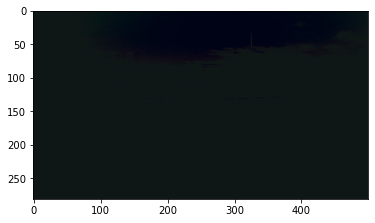

In [23]:
plt.imshow(contrast_linear(img, alpha = 1, beta = 20) - image)

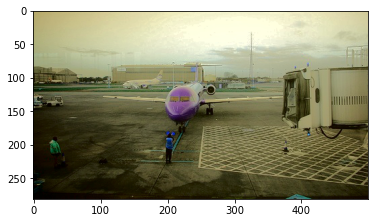

In [24]:
aug = iaa.HistogramEqualization()
image = aug.augment_image(img)
plt.imshow(image)

In [44]:
def hist_equalize(img):
    # 1. calclate hist
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])

    # 2. normalize hist
    h, w = img.shape[:2]
    hist = hist/(h*w)

      # 3. calculate CDF
    cdf = np.cumsum(hist)
    s_k = (255 * cdf - 0.5).astype("uint8")
    equalized_img = cv2.LUT(img, s_k)
    return equalized_img


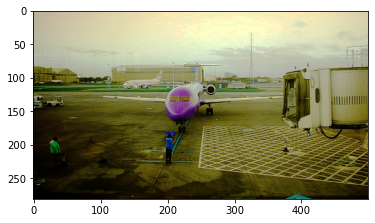

In [45]:
equalized_img = hist_equalize(img)

plt.imshow(equalized_img)

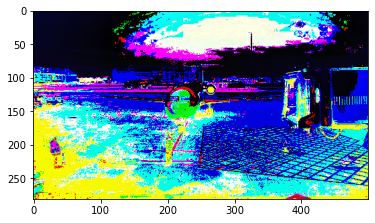

In [43]:
plt.imshow(equalized_img - image)

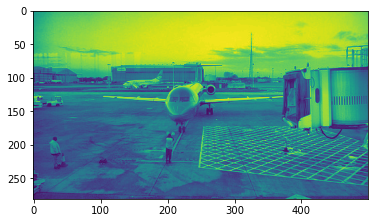

In [40]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equalized = cv2.equalizeHist(gray)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(gray)
plt.imshow(equalized)

[INFO] performing histogram equalization...


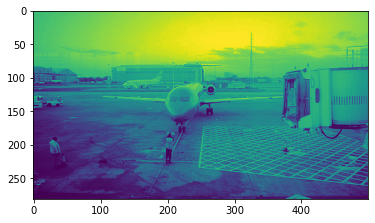

In [41]:

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# apply histogram equalization
print("[INFO] performing histogram equalization...")
equalized = cv2.equalizeHist(gray)
plt.imshow(equalized)

In [8]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
     
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [22]:
def contrast_linear(image, alpha = 0.5, beta = 20):
    
    '''
    out[pixel] = alpha * image[pixel] + beta
    '''
    output = np.zeros(image.shape, image.dtype)
    h, w, ch = image.shape
    print(ch)
    for y in range(h):
        for x in range(w):
            for c in range(ch):
                output[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)

    return output

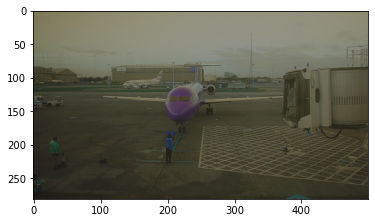

In [41]:
plt.imshow(contrast_linear(img, alpha = 0.5, beta = 20))

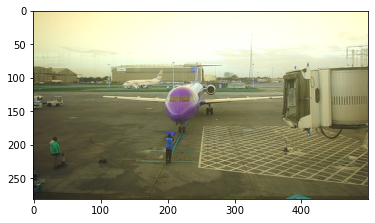

In [42]:
plt.imshow(contrast_linear(img, alpha = 1, beta = 20))